In [30]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import word_tokenize
from collections import Counter
from sklearn.linear_model import LinearRegression
%matplotlib inline
sns.set(color_codes = True)

In [2]:
#helper functions
# function to read in a file(txt,csv, xlsx, json) and convert to dataframe

def read_file(filepath):
    if re.search('txt',filepath):
        df = pd.read_csv(filepath)
    elif re.search('csv',filepath) or re.search('txt',filepath):
        df = pd.read_csv(filepath)
    else:
        df = df = pd.read_excel(filepath)
    return df

#function for basic description of dataset (head, info, describe,null,columns)
def summarize_data(data,metric):
    if metric == 'head':
        print(data.head())
    elif metric == 'info':
        print(data.info())
    elif metric == 'describe':
        print(data.describe())
    else:
        total = data.isnull().sum().sort_values(ascending = False)
        percent = (data.isnull().sum()/data.iloc[:,1].count()).sort_values(ascending = False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        print(missing_data.head(20))

        

In [5]:
#read the dataset
df = read_file('edmunds5.csv')

#Data analysis
summarize_data(df, 'head')
summarize_data(df,'info')
summarize_data(df,'null')


      author                                               body     dates
0  kdshapiro  braking - sorry the 70 to 0 braking of 189 rep...  4-Jan-04
1  kdshapiro  A new 2004 Accord drove up into my driveway la...  4-Jan-04
2       riez  For those who love numbers, compare performanc...  4-Jan-04
3    pg48477  kd, People buy TL over Accord, for the same re...  4-Jan-04
4       riez  pg48477... You prove my point. If luxury is th...  4-Jan-04
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  5000 non-null   object
 1   body    4988 non-null   object
 2   dates   5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB
None
        Total   Percent
body       12  0.002406
author      0  0.000000
dates       0  0.000000


In [8]:
df[df['body'].isnull() == True]

,author,body,dates
209,chrisboth,NaN,9-Jan-04
342,cjs2002,NaN,4-Feb-04
527,alibajalajaula,NaN,9-Mar-04
833,kahunah,NaN,9-Mar-04
1289,sweetc230,NaN,22-Mar-04
1290,pat,NaN,22-Mar-04
1444,fedlawman,NaN,23-Mar-04
1461,shipo,NaN,5-Apr-04
2615,pat,NaN,25-Feb-05
3497,taxesquire,NaN,5-Aug-05


In [11]:
df[df.duplicated() == True]

,author,body,dates
263,buddhabman,Are any of these sedans truly prestigous? Don'...,30-Jan-04
870,buddhabman,"It's because of these ""Purely Pedestrian"", ""Ch...",16-Mar-04
1268,buddhabman,Hands down give me the CTS-V over a 530i w/Spo...,12-Mar-04
1876,buddhabman,Aero 9-5 Wagon 6 CD changer standard vs 1 Disc...,7-Apr-04
2404,buddhabman,You ought to read more reviews on the new turb...,17-Aug-04
2431,buddhabman,Most of the new AWD cars with 300HP don't have...,18-Aug-04
3243,frisconick,lol,16-Jun-05


### Task A: 

Once you fetch the data, test if the data support Zipf’s law econometrically. Additionally plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

In [15]:
#creating some helper functions
def split_words(reviews):
    corpus = ""
    for words in reviews:
        corpus += words
    return corpus

def zipf_frequency(most_common_count, n=100):
    zipf_law = []
    for x in range(1, n+1):
        zipf_law.append(most_common_count/(x))
    return zipf_law

In [20]:
#cleaning data to convert it to string and remove any character which is not alphanumeric or whitespace
df['body'] = df['body'].astype(str)
df['body']=df['body'].apply(lambda e : re.sub(r'[^\w\s]','',str(e)).replace('\n',' ') )

In [26]:
#converting the entire text to lower string and storing it in a single string
corpus = split_words(df['body']).lower()

#Separating out tokens/words from corpus
tokens = nltk.word_tokenize(corpus)

#creating a dict of word frequencies 
word_frequencies =Counter(tokens)

Text(0, 0.5, 'Frequency of a Word')

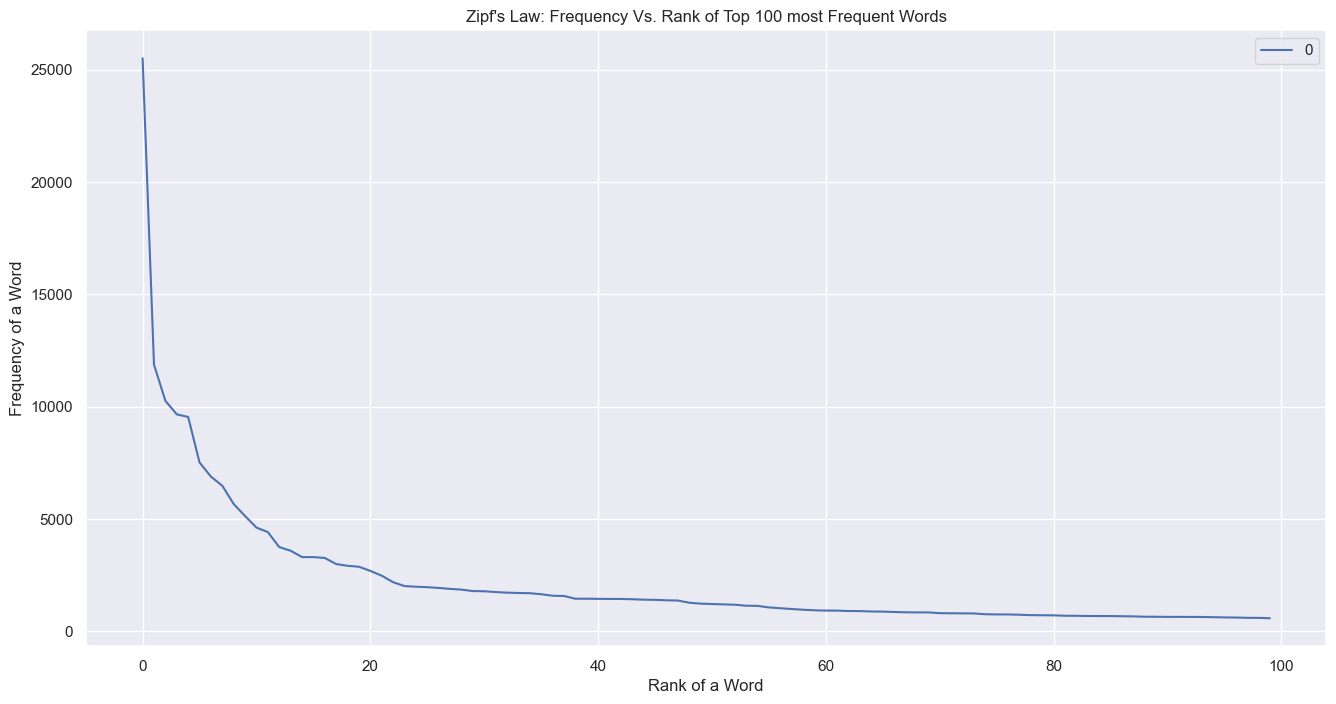

In [28]:
#Calculating and plotting the frequency distribution of most used 100 words

#Create top 100 words dict
top_100_words= dict(word_frequencies.most_common(100))

#plot frequency distribution
pd.Series(top_100_words).reset_index().plot(kind='line',figsize=(16,8),xlabel='Word Rank',ylabel='Word Frequency')
plt.title('Zipf\'s Law: Frequency Vs. Rank of Top 100 most Frequent Words')
plt.xlabel('Rank of a Word')
plt.ylabel('Frequency of a Word')

### At first glance the dataset appears to follow Zipf's law as the frequency of a word declines exponentially in relation to the rank of a word

Zipf's law is an empirical law that often holds, approximately, when a list of measured values is sorted in decreasing order. It states that the value of the nth entry is inversely proportional to n.

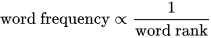

Source: https://en.wikipedia.org/wiki/Zipf%27s_law



## Let us now try to see if this holds true using a statistical model

Converting the above equation to log-log so that we can use linear regression. We will treat log(word_frequency) as our dependent variable and log(word_rank) as our independent variable(IV). We will estimate the coefficient of our IV and try to see if that is close to 1.


In [39]:
#Creating a dataframe containing top 100 words with their frequencies and ranks

word_frequency_tuples = list(top_100_words.items())
zipf_df = pd.DataFrame(word_frequency_tuples, columns=['Word', 'Word_Frequency'])
zipf_df['Word_Rank'] = range(1, len(zipf_df) + 1)
zipf_df


,Word,Word_Frequency,Word_Rank
0,the,25503,1
1,a,11872,2
2,and,10262,3
3,to,9660,4
4,i,9545,5
...,...,...,...
95,also,627,96
96,them,621,97
97,because,608,98
98,330i,606,99


In [45]:
# Converting variables to "word_frequency" and "word_rank" variables to log-log and fitting a linear regression model
model=LinearRegression()

model.fit(np.log(zipf_df['Word_Rank']).to_frame(),np.log(zipf_df['Word_Frequency']))

#evaluating the coefficient of IV
print("Coefficient of DV is:", model.coef_)

Coefficient of DV is: [-0.86087292]


### We can see that the coefficient of our IV i.e. log(word_rank) is very close to 1 and hence we can be pretty confident that our data follows zipf's law

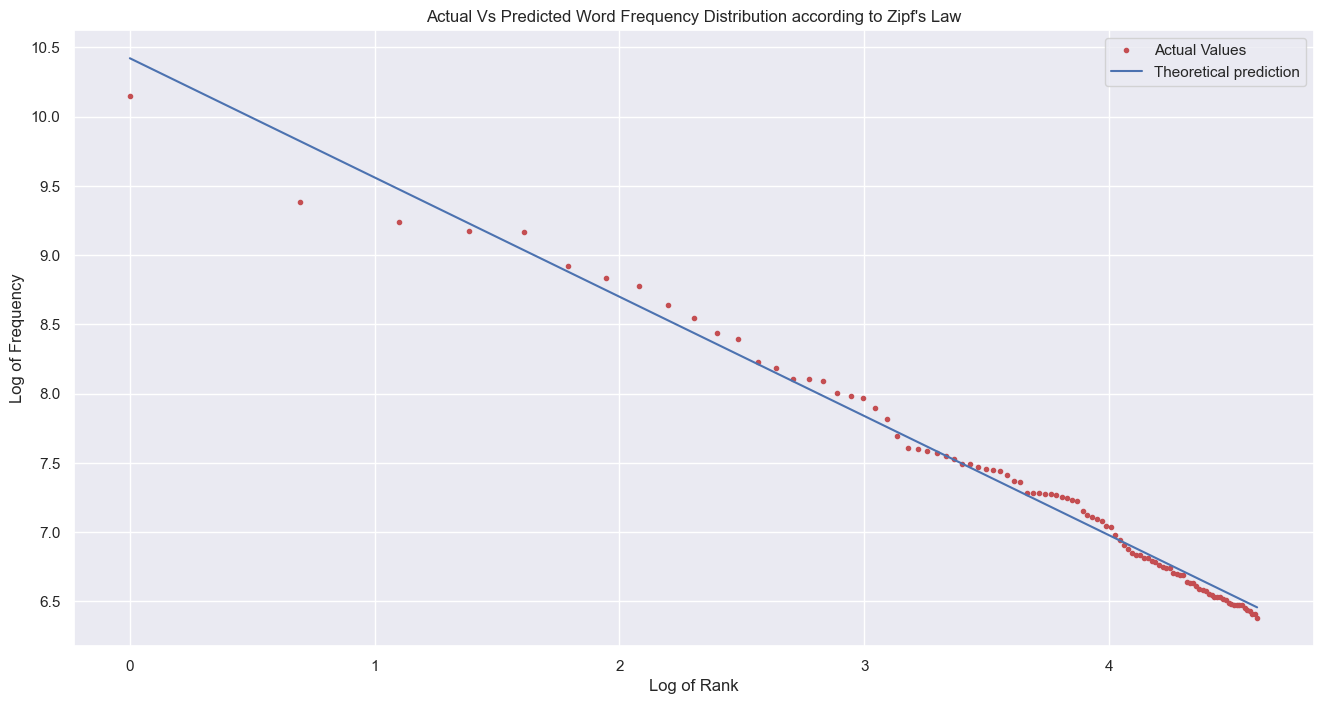

In [46]:
#plotting the actual data points vs the theoretical predicted values using Zipf's law for top100 words

plt.figure(figsize=(16,8))

plt.plot(np.log(zipf_df['Word_Rank']),np.log(zipf_df['Word_Frequency']),'r.',label='Actual Values ')
plt.plot(np.log(zipf_df['Word_Rank']),model.predict(np.log(zipf_df['Word_Rank']).to_frame()),label='Theoretical prediction')
plt.title('Actual Vs Predicted Word Frequency Distribution according to Zipf\'s Law')
plt.xlabel('Log of Rank')
plt.ylabel('Log of Frequency')

plt.legend()
plt.show()